## **RADI605: Modern Machine Learning**

### Assignment: Random Survival Forests
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/blob/main/05%20Adaptive%20Boosting/scripts/assignment.ipynb)

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import export as export 
import eli5
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from scipy.stats import reciprocal
from eli5.sklearn import PermutationImportance
from time import time
from sksurv.ensemble import RandomSurvivalForest
from sksurv.tree import SurvivalTree
from sksurv.datasets import load_flchain, load_gbsg2, load_whas500
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv

import sksurv.datasets
from sksurv.datasets import load_whas500
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ppscore as pps
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

#### Question 1: Please use a Worcester Heart Attack dataset <code>(whas500)</code>. Split whas500 into training and testing set (70:30).

In [26]:
X, y = load_whas500()
df_targets = pd.DataFrame(data = {'time': [y[i][1] for i in range(len(y))], 'event': [y[i][0] for i in range(len(y))]})
df_targets[:10].style.hide_index().highlight_min('event', color = 'yellow')

targets = ['fstat', 'lenfol']
data = pd.concat([X, pd.DataFrame(y.tolist(), columns = [targets[0], targets[1]])], axis = 1)
data['dead'] = np.where(data['fstat']==True, 1,0)
data = data.drop(columns=['fstat'])

print(f'Number of samples: {len(df_targets)}')
print(f'Number of right censored samples: {len(df_targets.query("event == False"))}')
print(f'Percentage of right censored samples: {100*len(df_targets.query("event == False"))/len(df_targets):.1f}%')


Number of samples: 500
Number of right censored samples: 285
Percentage of right censored samples: 57.0%


From the given dataset, it consists of 500 samples, 285 of which are right-censored samples. Take note that a right-censored sample is a type of data in survival analysis where the exact failure time of an event is not known. Instead, only the fact that the event has not occurred by a certain point in time (the censoring time) is known. The endpoint is death, which occurred for 215 patients (43.0%).

It is generally recommended to understand the correlation among features to understand the prediction of the Random Survival Forests. Here, we utilize a heatmap that displays the correlation of two pairs of features from the given dataset. The correlation between <code>age</code> and <code>bmi</code> is -0.402484, which indicates a moderate negative correlation between the two variables. Similarly, the correlation between <code>diasbp</code> and <code>sysbp</code> is 0.610916, which indicates a strong positive correlation.

<AxesSubplot:>

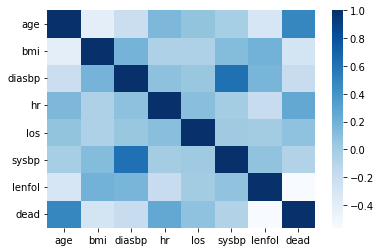

In [4]:
plt.figure(figsize = (6,4))
sns.heatmap(data.corr(),cmap = 'Blues', annot = False) 

Using <code>sklearn</code>, we utilized 30% of the dataset, consisting of 150 respondents, as our testing data. These data will be used for the evaluation of the random survival forest model to differen performance metrics, e.g., Concordance Indices, Survival Curve, Cumulative Hazard Function. The remaining data will serve as the RSF's training data.  

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

print(f'Number of training samples: {len(y_train)}')
print(f'Number of test samples: {len(y_test)}')

Number of training samples: 350
Number of test samples: 150


#### Build a random survival forest model by using training set <code>(X_train, y_train)</code>.

We performed a hyperparameter tuning to optimize the best parameters for Random Survival Forest. The hyperparameters are cross-validated at 3 splits with shuffle to increase randomicity and perform good generalization during training. 

In [6]:
def encoding(X, scale):
    if scale is True:
        cols = [type for type in X.columns if X[type].dtype.kind in ['i', 'f']]
    else:
        cols = [type for type in X.columns if X[type].dtype.kind not in ['i', 'f']]
    return cols

preprocessor = ColumnTransformer([('cat-preprocessor', OrdinalEncoder(), 
                                    encoding(X, scale = False)),
                                  ('standard-scaler',  StandardScaler(), 
                                    encoding(X, scale = True))],
                                  remainder = 'passthrough', sparse_threshold = 0)

param_grid =  {'n_estimators': [100, 300, 1000],
               'max_depth': [3, 5, 7],
               'min_samples_split': [2, 5, 7, 10],
               'min_samples_leaf':  [2, 5, 7, 15]}


start = time()
cv = KFold(n_splits = 3, shuffle=True, random_state=1)
survival_forest = GridSearchCV(RandomSurvivalForest(n_jobs = -1, random_state = 42), 
                           param_grid, 
                           cv = cv, 
                           scoring = concordance_index)
survival_forest.fit(X_train, y_train)
best_survival = survival_forest.best_estimator_
print(f"\t Fit and predict time of Random Survival Forest: {np.round(time() - start, 3)} seconds")

	 Fit and predict time of Random Survival Forest: 444.321 seconds


In [48]:
def plot_curve(survival_forest, X, var, survival_function = True, bmi = False):
    if bmi is False:
        group1 = X[X[var] < statistics.median(X[var])]
        group2 = X[X[var] > statistics.median(X[var])]
        set = statistics.median(X[var])
    else:
        group1 = X[X[var] < 25.00]
        group2 = X[X[var] > 25.00]
        set = 25.00

    if survival_function is True:
        surv_group1 = survival_forest.predict_survival_function(group1.head(5), return_array = True)
        surv_group2 = survival_forest.predict_survival_function(group2.head(5), return_array = True)

    else:
        surv_group1 = survival_forest.predict_cumulative_hazard_function(group1.head(5), return_array = True)
        surv_group2 = survival_forest.predict_cumulative_hazard_function(group2.head(5), return_array = True)
    
    fig, (ax1, ax2) = plt.subplots(figsize = (13, 5), nrows = 1, ncols = 2)
    for s, i in zip(surv_group1, group1.head(5).index):
        ax1.step(survival_forest.event_times_, s, where = 'post', label = 'Patient ' + str(i))
    ax1.set_ylabel('Survival Probability')
    ax1.set_xlabel('Time in days')
    ax1.legend()
    ax1.grid(True)
    ax1.set_title(f'Top 5 patients based on median {var} ({var} < {set})', size = 10)

    for s, i in zip(surv_group2, group2.head(5).index):
        ax2.step(survival_forest.event_times_, s, where = 'post', label = 'Patient ' + str(i))
    ax2.set_ylabel('Survival Probability')
    ax2.set_xlabel('Time in days')
    ax2.legend()
    ax2.grid(True)
    ax2.set_title(f'Top 5 patients based on median {var} ({var} > {set})', size = 10)
    return surv_group1, surv_group2

#### Plot survival curve

The illustration below depicts the survival function as a step plot in terms of the variables <code>age</code> and <code>bmi</code>. Additionally, other covariates can be employed to assess the survival probability based on their respective features. In this context, we first consider <code>age</code>. The x-axis signifies the passage of time in days, while the y-axis indicates the likelihood of survival. At the starting point, the survival probability is 1.0, signifying that 100% of the participants are alive.

The figure in the top left corner displays the top 5 patients with <code>age < 71</code>. It reveals that these patients have a mean survival of around 2400 days (equivalent to 6.57 years). However, it can be observed that the survival rate of Patient #374 is declining at a faster pace than the other patients, despite being the youngest among the five patients with an age of 44. This contradicts the conventional belief that older patients tend to have a higher mortality rate than younger individuals. Similarly, the figure in the top right corner exhibits a mean survival rate similar to that of patients with ages greater than the median age. Nonetheless, Patient #104, who is 91 years old, has a longer survival rate compared to Patient #124, who is 72 years old.

Similar to <ode>age</code>, we present <code>bmi</code> in terms of the median. The bottom-left figure shows the top 5 patients with <code>bmi < 25.00</code> - that is, underweight to normal. It shows that people with this BMI scale has distributed survival rate through time. Figure shows that Patient #388, whose BMI is 23.83, has faster decline of survival than the other patients. Meanwhile, Patient #374 has a higher survival rate among the five patients. 

In [52]:
var = 'bmi'
X_test[X_test[var] < 25].head()

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
73,0,77.0,0,24.87489,0,0,48.0,1,97.0,4.0,0,0,0,98.0
374,0,44.0,0,21.30550,0,0,48.0,0,66.0,3.0,0,0,0,89.0
450,0,82.0,0,18.60004,1,1,61.0,1,91.0,9.0,0,1,0,135.0
194,0,54.0,0,21.96609,1,0,60.0,0,115.0,16.0,0,1,0,124.0
388,0,104.0,0,23.82665,1,0,53.0,1,92.0,3.0,0,0,0,126.0


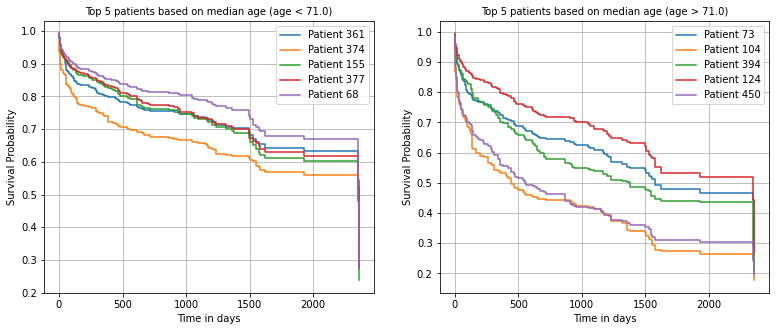

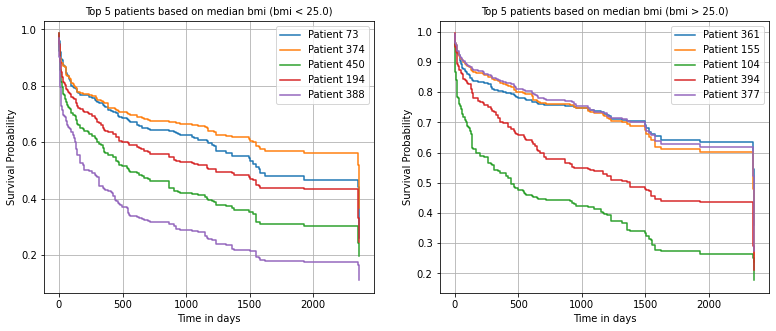

In [49]:
age_group1, age_group2 = plot_curve(best_survival, X_test, var = 'age')
age_group1, age_group2 = plot_curve(best_survival, X_test, var = 'bmi', bmi = True)

#### Plot the predicted cumulative hazard function

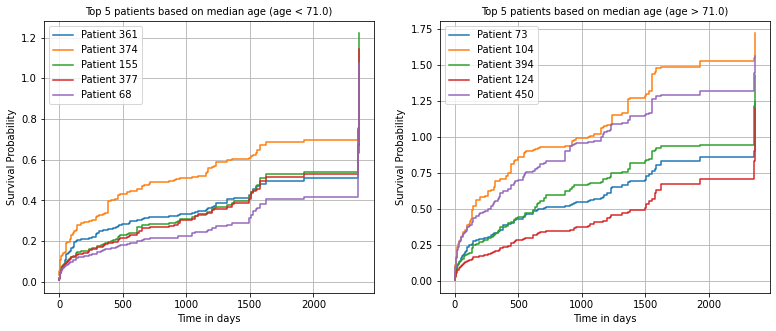

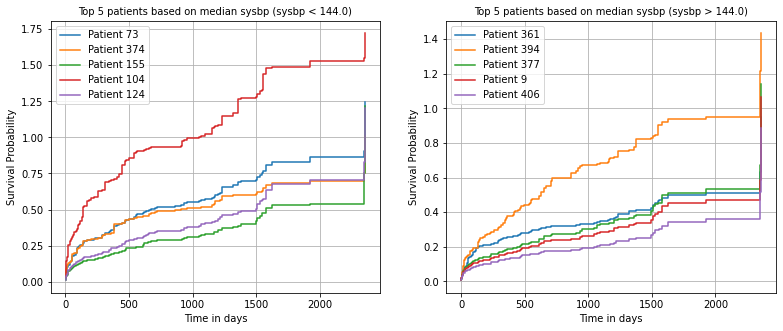

In [10]:
age_group1, age_group2 = plot_curve(best_survival, X_test, var = 'age',   survival_function = False)
age_group1, age_group2 = plot_curve(best_survival, X_test, var = 'sysbp', survival_function = False)

#### Evaluate your model performance by using testing set <code>(X_test, y_test)</code>.

Using the test data, we want to assess how well the model <code>best_survival</code> can distinguish survivors from deceased. The plot below shows that the model is performing well until the near-55th day. The performance between the first and second halves of the time range, however, clearly differs. Performance on the test data at near-55th day suddenly declines after enrollment, and then continues to decline until the 150th day. Note that the higher the AUC, the better the model is at predicting which individuals are more likely to experience death.

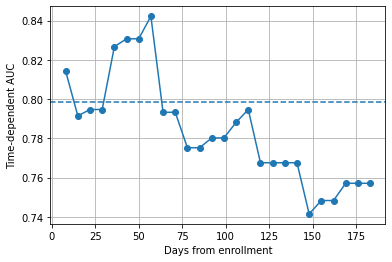

In [11]:
times = np.arange(8, 184, 7)
risk_score = best_survival.predict(X_test)
survival_auc, survival_mauc = cumulative_dynamic_auc(y_train, y_test,
                                                     risk_score, times)
plt.plot(times, survival_auc, marker = 'o')
plt.axhline(survival_mauc, linestyle = '--')
plt.xlabel('Days from enrollment')
plt.ylabel('Time-dependent AUC')
plt.grid(True)                                      

The most frequently used evaluation metric of survival models is the concordance index.

In [12]:
predictions = best_survival.predict(X_test)
c_index = concordance_index_censored(y_test[targets[0]], y_test[targets[1]], predictions)
print(f'The c-index of Random Survival Forest is given by {c_index[0]:.5f}')

The c-index of Random Survival Forest is given by 0.75030


A c-index of 0.75547 indicates that the Random Survival Forest model has a moderate ability to correctly rank pairs of patients in terms of their risk of death.

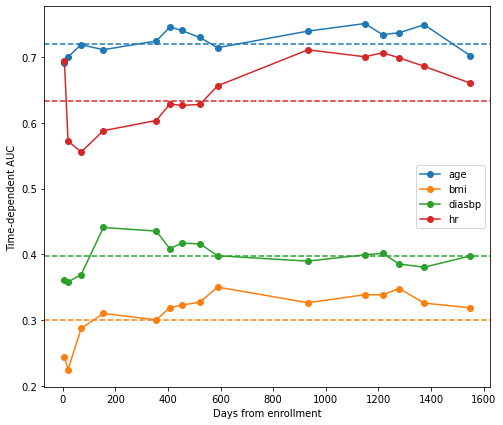

In [13]:
def get_correlated(df, threshold = 0.99):
    corr = df.corr()
    corr = corr[corr > threshold]
    corr = corr.dropna(axis = 1, how = 'all')
    corr = corr.dropna(axis = 0, how = 'all')
    vars_list = [col for col in corr.columns if any(corr[col].abs() > threshold)]

    for item in ['lenfol', 'dead']:
        vars_list.remove(item)
    return vars_list

def plot_cumulative_dynamic_auc(risk_score, label, color = None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)
    plt.plot(times, auc, marker="o", color = color, label=label)
    plt.xlabel('Days from enrollment')
    plt.ylabel('Time-dependent AUC')
    plt.axhline(mean_auc, color=color, linestyle = '--')
    plt.legend()

times = np.percentile(y[targets[1]], np.linspace(5, 81, 15))
num_columns = get_correlated(data)[:-2]

imputer = SimpleImputer().fit(X_train.loc[:, num_columns])
X_test_imputed = imputer.transform(X_test.loc[:, num_columns])

plt.figure(figsize = (8, 7))
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(X_test_imputed[:, i], col, color = 'C{}'.format(i))
    ret = concordance_index_ipcw(y_train, y_test, X_test_imputed[:, i], tau = times[-1])

We acquired the features with the highest correlation to the target variables. These features include the <code>age</code>, <code>bmi</code>, <code>diasbp</code>, and <code>hr</code>. We used these features to analyze their relationship to the respondent's survival through time. The plot above shows the estimated area under the time-dependent ROC at each time point and the average across all time points as dashed line.

####  Summarize the results